```{index} single: logistics
```
```{index} single: solver; highs
```
```{index} network optimization
```
```{index} min-cost flow problem
```
```{index} networkx
```

# Minimum-Cost Flow Problem

## Preamble: Install Pyomo and a solver

This cell selects and verifies a global SOLVER for the notebook. If run on Google Colab, the cell installs Pyomo and HiGHS.

Then, we set SOLVER to use the HiGHS solver via the Pyomo SolverFactory and verify that SOLVER is available.

In [1]:
import sys
 
if 'google.colab' in sys.modules:
    !pip install pyomo >/dev/null 2>/dev/null
    !pip install highspy >/dev/null 2>/dev/null
 
solver = 'appsi_highs'
 
import pyomo.environ as pyo
SOLVER = pyo.SolverFactory(solver)
 
assert SOLVER.available(), f"Solver {solver} is not available."

## Problem description

In the context of logistics optimization, a company aims to identify the most cost-effective strategy for transporting goods from its production facilities to its retail locations across an entire continent. 

This problem can be naturally formulated using a graph. Each node $j \in V$ of this network represents a manufacturing facility, a distribution center, or a retail outlet. Correspondingly, node $j$ is characterized by having a supply $b_j>0$, a demand $b_j<0$, or just serving as a transshipment point with $b_j=0$. Each directed arc $(i,j) \in E$ represents a possible mode of transport (rail, airway, road) between locations $i$ and $j$, with an associated maximum capacity $u_{ij} \geq 0$ and cost $c_{ij} \geq 0$ per unit of good sent using edge $(i,j)$. Note that multiple edges are possible between the same pair of nodes $(i,j)$, modeling different means of transport available between those locations, each with a specific cost and maximum capacity. The goal is to identify the cheapest way of transporting goods from the supply nodes to the demand nodes, while respecting the capacity constraints of the arcs and the supply/demand constraints of the nodes.

## Mathematical formulation 

For every edge $(i,j) \in E$, we introduce a decision variable $x_{ij} \geq 0$ describing the non-negative amount of goods sent from node $i$ to node $j$ via edge $(i,j) \in E$. These quantities are usually referred to as *flows*. The **Minimum-Cost Flow (MCF)** problem aims to find the set of flows $\{x_{ij}\}_{(i,j)\in E}$ with the minimum cost through the network such that the available supply is used to satisfy the demand. It can be formulated as follows:

$$
\begin{align*}
\min & \sum_{(i, j) \in E} c_{i j} x_{i j} \\
\text {s.t. } & \sum_{i:(j, i) \in E} x_{j i}-\sum_{i:(i, j) \in E} x_{i j}=b_{j}, & \forall j \in V \\
& 0 \leq x_{i j} \leq u_{i j}, & \forall(i, j) \in E
\end{align*}
$$

The first set of constraints, usually referred to as *flow conservation* or *balance* constraints, expressing the fact that the net balance of the goods arriving at node $j$ minus those departing from node $j$ should be exactly equal to the supply/demand $b_j$ set for that node.

Let us now solve the MCF problem for the following small network instance, specified using dictionaries. 

In [2]:
network = {
    "nodes": {
        0: {"b": 15},
        1: {"b": 0},
        2: {"b": 0},
        3: {"b": 0},
        4: {"b": -1},
        5: {"b": -1},
        6: {"b": -2},
        7: {"b": -2},
        8: {"b": -2},
        9: {"b": -2},
        10: {"b": -5},
    },
    "edges": {
        (0, 1): {"u": 15, "c": 1},
        (1, 2): {"u": 15, "c": 1},
        (2, 9): {"u": 10, "c": 1},
        (2, 3): {"u": 15, "c": 1},
        (3, 4): {"u": 15, "c": 1},
        (3, 5): {"u": 10, "c": 2},
        (3, 4): {"u": 10, "c": 3},
        (4, 7): {"u": 4, "c": 1},
        (4, 8): {"u": 5, "c": 4},
        (5, 8): {"u": 5, "c": 3},
        (5, 9): {"u": 6, "c": 2},
        (5, 10): {"u": 5, "c": 1},
        (8, 6): {"u": 8, "c": 3},
        (6, 10): {"u": 1, "c": 3},
        (7, 8): {"u": 4, "c": 2},
        (7, 10): {"u": 2, "c": 2},
        (8, 10): {"u": 5, "c": 3},
        (9, 10): {"u": 3, "c": 1},
    },
}

We first introduce an auxiliary function to draw the network and its features.

In [3]:
import matplotlib.pyplot as plt
from networkx import (
    DiGraph,
    layout,
    draw,
    draw_networkx_labels as draw_labels,
    draw_networkx_edge_labels as draw_edge_labels,
    draw_networkx_edges as draw_edges,
)
from IPython.display import HTML, Markdown


def draw_network(network, ax=None, edge_flows=None):
    g = DiGraph(network["edges"].keys())
    pos = layout.kamada_kawai_layout(g, weight=None)
    draw(g, pos=pos, ax=ax, with_labels=True, font_color="white")
    if not (edge_flows is None):
        F = {k: v for k, v in edge_flows.items() if v > 0}
        draw_edges(
            g,
            pos=pos,
            edgelist=F.keys(),
            width=10,
            edge_color="lightblue",
            style="solid",
            alpha=None,
            arrowstyle="-",
        ),
    shifted_pos = {k: (x, y - 0.08) for k, (x, y) in pos.items()}
    for i, data in network["nodes"].items():
        label = ",".join(f"{k}={v}" for k, v in data.items())
        value = data.get("b", 0)
        if value < 0:
            color = "red"
        elif value == 0:
            color = "gray"
        else:
            color = "green"
        draw_labels(
            g,
            ax=ax,
            pos={i: shifted_pos[i]},
            labels={i: label},
            font_color=color,
            font_weight="bold",
        )
    if edge_flows is None:
        draw_edge_labels(
            g,
            pos=pos,
            ax=ax,
            font_size=9,
            edge_labels={
                i: ",".join(f"{k}={v}" for k, v in data.items())
                for i, data in network["edges"].items()
            },
        )
    else:
        draw_edges(g, pos=pos),
        draw_edge_labels(
            g, pos=pos, ax=ax, font_size=11, font_weight="bold", edge_labels=edge_flows
        )

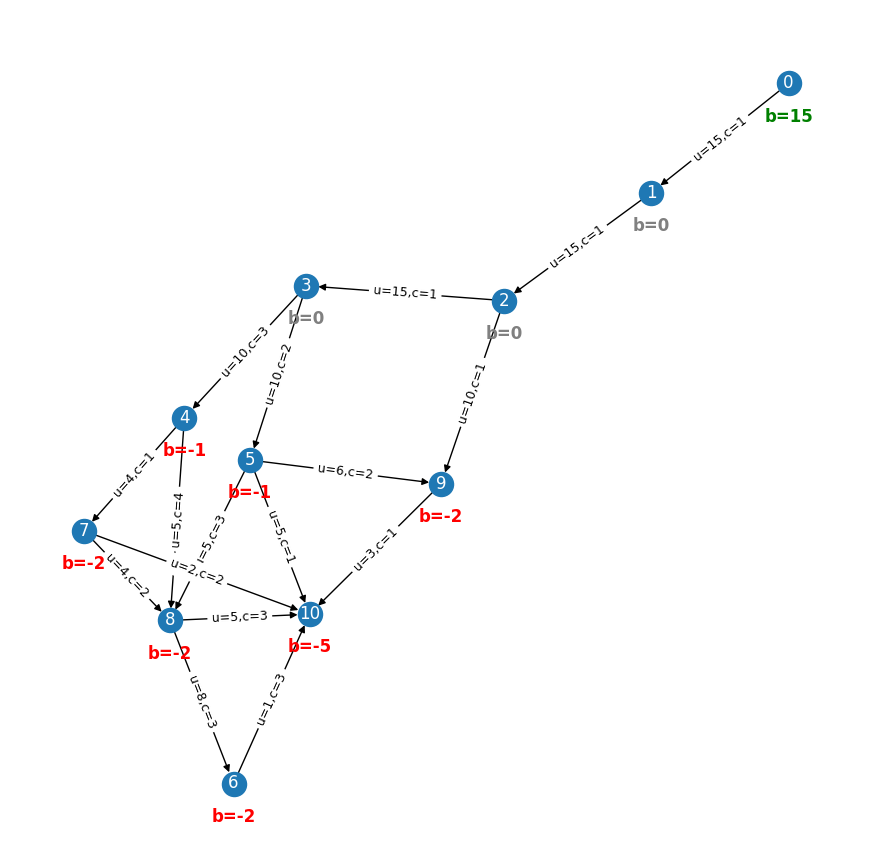

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(11, 11))
draw_network(network, ax=ax)

In the next cell, we formulate the MCF problem using Pyomo, solve it, and visualize the solution.


Optimal solution:


$x_{(0, 1)} = 15$, $x_{(1, 2)} = 15$, $x_{(2, 9)} = 5$, $x_{(2, 3)} = 10$, $x_{(3, 4)} = 3$, $x_{(3, 5)} = 7$, $x_{(4, 7)} = 2$, $x_{(4, 8)} = 0$, $x_{(5, 8)} = 4$, $x_{(5, 9)} = 0$, $x_{(5, 10)} = 2$, $x_{(8, 6)} = 2$, $x_{(6, 10)} = 0$, $x_{(7, 8)} = 0$, $x_{(7, 10)} = 0$, $x_{(8, 10)} = 0$, $x_{(9, 10)} = 3$

Objective value: 93


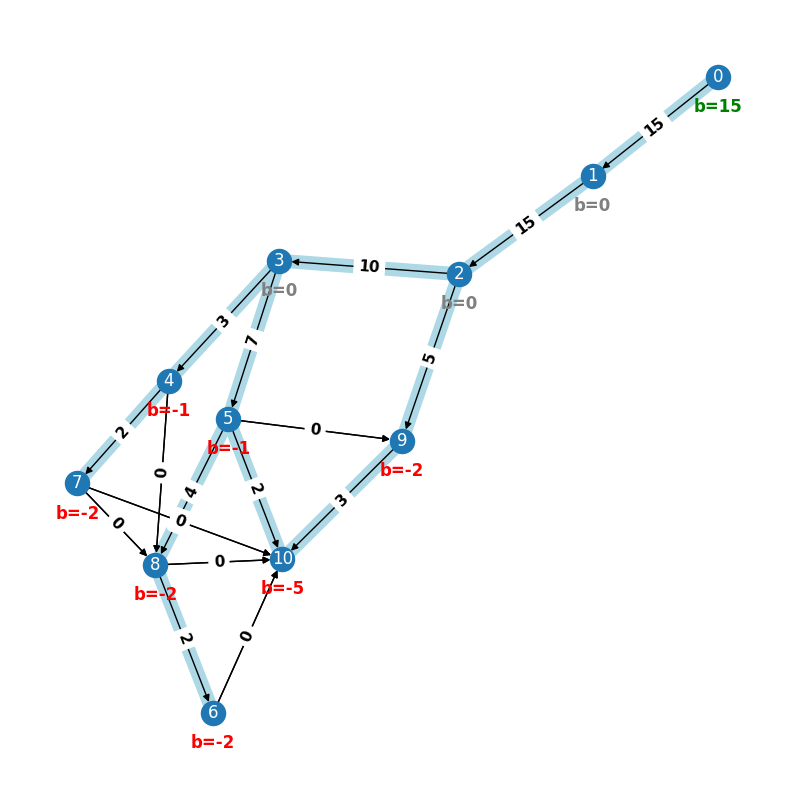

In [6]:
def mincostflow(network):
    model = pyo.ConcreteModel("Minimum cost flow")

    model.x = pyo.Var(network["edges"], domain=pyo.NonNegativeReals)

    @model.Objective(sense=pyo.minimize)
    def objective(m):
        return sum(data["c"] * m.x[e] for e, data in network["edges"].items())

    @model.Expression(network["nodes"])
    def incoming_flow(m, j):
        return sum(m.x[i, j] for i in network["nodes"] if (i, j) in network["edges"])

    @model.Expression(network["nodes"])
    def outgoing_flow(m, j):
        return sum(m.x[j, i] for i in network["nodes"] if (j, i) in network["edges"])

    @model.Constraint(network["nodes"])
    def flow_conservation(m, j):
        return m.outgoing_flow[j] - m.incoming_flow[j] == network["nodes"][j]["b"]

    @model.Constraint(network["edges"])
    def flow_upper_bound(m, *e):
        return m.x[e] <= network["edges"][e]["u"]

    SOLVER.solve(model)

    flows = {e: round(model.x[e].value) for e in network["edges"]}

    return model, flows


model, flows = mincostflow(network)
print(f"\nOptimal solution:")
display(
    Markdown(
        ", ".join("$x_{%s} = %d$" % (e, model.x[e].value) for e in network["edges"])
    )
)
print(f"Objective value: {model.objective():.0f}")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
draw_network(network, ax=ax, edge_flows=flows)